# Customer Segmentation using RFM Analysis
# Dataset: Online Retail (UK-based transactions)
# Objective: Identify target demographics and segment customers
# Factors: Recency (days since last purchase), Frequency (unique orders),
#          Monetary (total spend)


In [4]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

# Load data (adjust path as needed)
df = pd.read_csv("data.csv", encoding='ISO-8859-1')

# Step 1: Data Cleaning
# Remove entries with missing CustomerID and negative quantities
df_clean = df.dropna(subset=['CustomerID'])
df_clean = df_clean[df_clean['Quantity'] > 0]

# Convert InvoiceDate to datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Step 2: Define Snapshot Date (1 day after latest transaction)
snapshot_date = df_clean['InvoiceDate'].max() + dt.timedelta(days=1)

# Step 3: Compute RFM Metrics
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'UnitPrice': lambda x: (x * df_clean.loc[x.index, 'Quantity']).sum()  # Monetary
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Step 4: Assign Quartiles to RFM
# Recency Quartiles (lower is better)
rfm['R_Quartile'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])

# Handle Frequency and Monetary with custom binning due to unique value limits
freq_quantiles = rfm['Frequency'].quantile([0, 0.33, 0.66, 1]).unique()
mon_quantiles = rfm['Monetary'].quantile([0, 0.25, 0.5, 0.75, 1]).unique()

freq_labels = list(range(1, len(freq_quantiles)))  # [1, 2, 3]
mon_labels = list(range(1, len(mon_quantiles)))    # [1, 2, 3, 4]

rfm['F_Quartile'] = pd.cut(rfm['Frequency'], bins=freq_quantiles, labels=freq_labels, include_lowest=True)
rfm['M_Quartile'] = pd.cut(rfm['Monetary'], bins=mon_quantiles, labels=mon_labels, include_lowest=True)

# Step 5: Create RFM Segment and Score
rfm['RFM_Segment'] = rfm['R_Quartile'].astype(str) + rfm['F_Quartile'].astype(str) + rfm['M_Quartile'].astype(str)
rfm['RFM_Score'] = rfm[['R_Quartile', 'F_Quartile', 'M_Quartile']].astype(int).sum(axis=1)

# Step 6: Display top records
print(rfm.head(10))

            Recency  Frequency  Monetary R_Quartile F_Quartile M_Quartile  \
CustomerID                                                                  
12346.0         326          1  77183.60          1          1          4   
12347.0           2          7   4310.00          4          2          4   
12348.0          75          4   1797.24          2          1          4   
12349.0          19          1   1757.55          3          1          4   
12350.0         310          1    334.40          1          1          2   
12352.0          36          8   2506.04          3          2          4   
12353.0         204          1     89.00          1          1          1   
12354.0         232          1   1079.40          1          1          3   
12355.0         214          1    459.40          1          1          2   
12356.0          23          3   2811.43          3          1          4   

           RFM_Segment  RFM_Score  
CustomerID                         
123

In [2]:
#Save segmented customers to CSV
rfm.to_csv("rfm_segmented_customers.csv")

Segment counts:
 At Risk            1958
Loyal Customers     969
Champions           894
Dormant             518
Name: Segment, dtype: int64


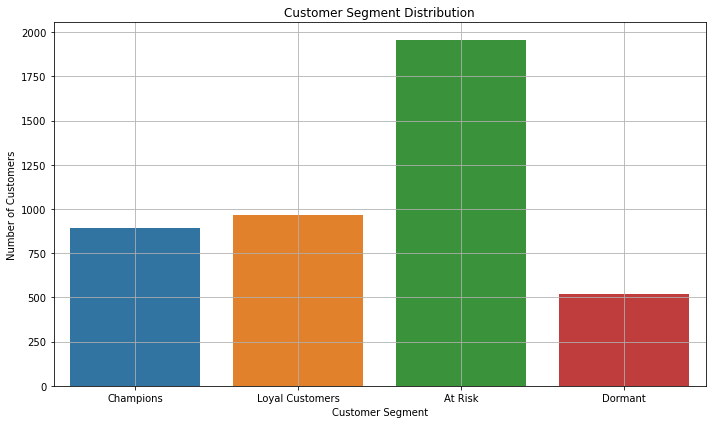

In [7]:
# Ensure all required columns are present and not null
rfm = rfm.dropna(subset=['RFM_Score'])

# Reassign customer segments safely
def assign_segment(score):
    try:
        score = int(score)
        if score >= 9:
            return 'Champions'
        elif score >= 7:
            return 'Loyal Customers'
        elif score >= 4:
            return 'At Risk'
        else:
            return 'Dormant'
    except:
        return 'Unknown'

rfm['Segment'] = rfm['RFM_Score'].apply(assign_segment)

# Check unique segment counts (debug step)
print("Segment counts:\n", rfm['Segment'].value_counts())

# Plot segment distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=rfm, x='Segment', order=['Champions', 'Loyal Customers', 'At Risk', 'Dormant'])
plt.title('Customer Segment Distribution')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.tight_layout()
plt.show()
